In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tqdm
import pdb
import time
import pdb
import timeit

In [59]:
# Functions from SVM.ipynb

def get_toy_svm_dataset_linear_binary(num_samples=100, num_features=2, noise=0, w=None, b=None):
    if noise != 0:
        warnings.warn('noise not implemented. data will be linearly separable')
    X = (np.random.rand(num_samples, num_features) - 0.5) * 3
    if w is None:
      w = np.random.rand(num_features) - 0.5
    if b is None:
      b = np.random.rand(1) - 0.5
    y = ((X @ w) + b > 0).astype(int)
    y[y==0] = -1
    return X, y, w, b

def get_decision_boundary_points_2D(X, w, b):
    assert w.shape == (2,), "must have two weights"
    assert b.shape == (1,), "b must be scalar"
    assert X.shape[1] == 2, "X must have two features"

    x = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
    y = (- ((x * w[0]) + b)) / w[1]
    return x, y

def g(z):
    y_hat = z.astype(int)
    y_hat[y_hat==0] = -1
    return y_hat

def get_functional_margin(X, y, w, b):
    # if y = 1, need X@w+b to be large positive to get large positive output
    # opposite is true if y = -1
    # thus, a large positive functional margin tells us a sample is far away from the hyperplane and classified correctly
    # negative tells us that the classification is incorrect

    # gamma_hat --> all functional margins 
    gamma_hat = (y * (X @ w + b))
    return gamma_hat

def get_functional_margin_wrt_S(X, y, w, b):
    # S --> set of training examples
    gamma_hat = get_functional_margin(X, y, w, b)
    gamma_hat_wrt_S = np.min(gamma_hat) # the worst one
    return gamma_hat_wrt_S

def normalize_vector(v):
    # could use np.linalg.norm but that would break the rules :)
    norm = np.sqrt(np.sum(v**2))
    return v / norm

def get_geometric_margin(X, y, w, b):
    w_norm = np.sqrt(np.sum(w**2))

    # all geometric margins
    gamma = y * ((X @ (w / w_norm)) + (b / w_norm))

    return gamma

def get_geometric_margin_wrt_S(X, y, w, b):
    # S --> set of training examples
    gamma = get_geometric_margin(X, y, w, b)
    gamma_wrt_S = np.min(gamma) # the closest one; a support vector
    return gamma_wrt_S

def get_kernel(x1, x2, kernel_type = 'linear'):
    # phi = feature mapping
    if kernel_type == 'linear':
        phi = lambda x: x
        return np.dot(phi(x1), phi(x2))

    if kernel_type == 'gaussian':
        raise NotImplementedError()

    raise ValueError(f'Kernel {kernel_type} not supported')

def get_kernel_matrix(X, kernel_type = 'linear'):
    # this could probably be vectorized
    num_samples = X.shape[0]
    kernel_matrix = np.zeros(shape=(num_samples, num_samples))
    for i in range(num_samples):
        x1 = X[i]
        for j in range(num_samples):
            x2 = X[j]
            K_i_j = get_kernel(x1, x2, kernel_type)
            kernel_matrix[i, j] = K_i_j
    return kernel_matrix

def get_initial_alpha(num_samples, y):
    # "alpha" = vector filled with lagrange multipliers
    # generate random alphas for negative samples
    alpha = np.zeros_like(y, dtype=float)
    num_negative = np.sum(y==-1)
    alpha[y == -1] = np.random.rand(num_negative) * 0.1

    # get dot product to compute scaling factor for positive samples
    initial_dot = alpha @ y

    # count positive samples
    num_positive = np.sum(y == 1)

    # initial random alphas for positive samples
    random_alpha_for_positive_samples = np.random.rand(num_positive)

    # normalize so they sum to 1
    norm_alpha_for_positive_samples = random_alpha_for_positive_samples / np.sum(random_alpha_for_positive_samples)
    assert np.isclose(np.sum(norm_alpha_for_positive_samples), 1), 'normalization of initial lagrange multipliers for positive samples failed: sum != 1'

    # scale with initial dot computed before
    scaled_alpha_for_positive_samples = -(norm_alpha_for_positive_samples * initial_dot)
    assert np.isclose(-np.sum(scaled_alpha_for_positive_samples), initial_dot), 'scaling of initial lagrange multipliers for positive samples failed: -sum != initial dot'

    # sub in alphas for positive samples
    alpha[y==1] = scaled_alpha_for_positive_samples

    # does this satisfy sum(alpha_i * y_i for all i) = 0 constraint?
    assert np.isclose(alpha @ y, 0), 'failed to generate random lagrange multipliers: alpha @ y != 0 '

    return alpha

def alpha_to_w(alpha, X, y):
    # express w in terms of lagrange mutlipliers (alphas), X, and y
    w = np.sum((alpha * y).reshape(-1, 1) * X, axis=0)

    # equivalent to: np.sum([alpha[i] * y[i] * X[i] for i in range(len(alpha))], axis=0)

    assert w.shape[0] == X.shape[1], f'mismatch between number of weights produced {w.shape[0]} and number of features {X.shape[1]}'

    return w

# objective function: maximize
def W_slow(alpha, K, y):
    first_part = np.sum(alpha)

    second_part = 0

    for i in range(len(alpha)):
        for j in range(len(alpha)):
              second_part += y[i] * y[j] * alpha[i] * alpha[j] * K[i, j]

    W_alpha = first_part - (0.5 * second_part)

    return W_alpha

def is_greater_or_close(a, b, rtol=1e-5, atol=1e-8):
    return np.logical_or(a > b, np.isclose(a, b, rtol=rtol, atol=atol))

def is_less_or_close(a, b, rtol=1e-5, atol=1e-8):
    return np.logical_or(a < b, np.isclose(a, b, rtol=rtol, atol=atol))

def check_KKT(X, y, alpha, c, w, b, tol=0.01):
    # karush-kuhn-tucker conditions. tests for convergence
    # 'tol' here is absolute tolerance. Could also use relative tolerance
    # Ng : "Here, tol is the convergence tolerance parameter, and is typically set to around 0.01 to 0.001"
    warnings.warn('this function has not been tested at all')

    kkt_results = {}
    gamma_hat = get_functional_margin(X, y, w, b) # use geometric margin? idk work this out

    # αi = 0 ⇒ yi(xi @ w + b) >= 1
    condition_1_bool = is_greater_or_close(gamma_hat[alpha == 0], 1, rtol=0, atol=tol)
    condition_1_passed = np.all(condition_1_bool)
    kkt_results['condition_1'] = condition_1_passed

    # αi = C ⇒ yi(xi @ w + b) <= 1
    condition_2_bool = is_less_or_close(gamma_hat[alpha == c], 1, rtol=0, atol=tol)
    condition_2_passed = np.all(condition_2_bool)
    kkt_results['condition_2'] = condition_2_passed

    # 0 < αi < C ⇒ yi(xi @ w + b) = 1
    condition_3_bool = np.isclose(gamma_hat[(alpha > 0) & (alpha < c)], rtol=0, atol=tol)
    condition_3_passed = np.all(condition_3_bool)
    kkt_results['condition_3'] = condition_3_passed

    return kkt_results

# SMO (Raw)

In [60]:
# create binary dataset
num_samples = 100
num_features = 2
noise = 0

X, y, w_optimal, b_optimal = get_toy_svm_dataset_linear_binary(num_samples, num_features, noise)

<Axes: >

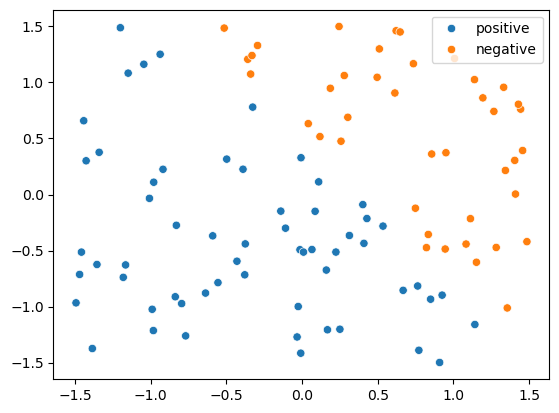

In [61]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=['negative' if val == -1 else 'positive' for val in y])

In [111]:
alpha = get_initial_alpha(num_samples, y)

# constrained to = 0
alpha @ y

np.float64(-6.938893903907228e-18)

In [112]:
alpha.dtype

dtype('float64')